In [1]:
# Uncomment to run the notebook in Colab
# ! pip install -q "wax-ml[complete]@git+https://github.com/eserie/wax-ml.git"
# ! pip install -q --upgrade jax jaxlib==0.1.70+cuda111 -f https://storage.googleapis.com/jax-releases/jax_releases.html

In [5]:
# check available devices
import jax

In [6]:
print("jax backend {}".format(jax.lib.xla_bridge.get_backend().platform))
jax.devices()

jax backend cpu


# ⏱ Synchronize data streams ⏱

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eserie/wax-ml/blob/main/docs/notebooks/02_Synchronize_data_streams.ipynb)

Physicists, and not the least 😅, have brought a solution to the synchronization
problem.  See [Poincaré-Einstein synchronization Wikipedia
page](https://en.wikipedia.org/wiki/Einstein_synchronisation) for more details.

In WAX-ML we strive to follow their recommendations and implement a synchronization
mechanism between different data streams. Using the terminology of Henri Poincaré (see
link above), we introduce the notion of "local time" to unravel the stream in which
the user wants to apply transformations. We call the other streams "secondary streams".
They can work at different frequencies, lower or higher.  The data from these secondary
streams will be represented in the "local time" either with the use of a
forward filling mechanism for lower frequencies or a buffering mechanism
for higher frequencies.

We implement a "data tracing" mechanism to optimize access to out-of-sync streams.
This mechanism works on in-memory data.  We perform the first pass on the data,
without actually accessing it, and determine the indices necessary to
later access the data. Doing so we are vigilant to not let any "future"
information pass through and thus guaranty a data processing that respects causality.

The buffering mechanism used in the case of higher frequencies works with a fixed
buffer size (see the WAX-ML module
[`wax.modules.Buffer`](https://wax-ml.readthedocs.io/en/latest/_autosummary/wax.modules.buffer.html#module-wax.modules.buffer))
which allows us to use JAX / XLA optimizations and have efficient processing.

Let's illustrate with a small example how `wax.stream.Stream` synchronizes data streams.

Let's use the dataset "air temperature" with :
- An air temperature is defined with hourly resolution.
- A "fake" ground temperature is defined with a daily resolution as the air temperature minus 10 degrees.

In [7]:
import xarray as xr

dataset = xr.tutorial.open_dataset("air_temperature")
dataset["ground"] = dataset.air.resample(time="d").last().rename({"time": "day"}) - 10

/Users/emmanuelserie/mambaforge/envs/waxml39/lib/python3.9/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Let's see what this dataset looks like:

In [8]:
dataset

<xarray.Dataset>
Dimensions:  (day: 730, lat: 25, lon: 53, time: 2920)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
  * day      (day) datetime64[ns] 2013-01-01 2013-01-02 ... 2014-12-31
Data variables:
    air      (time, lat, lon) float32 ...
    ground   (day, lat, lon) float32 231.89 231.79999 ... 286.19 285.69
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [9]:
from wax.accessors import register_wax_accessors

register_wax_accessors()

In [10]:
from wax.modules import EWMA


def my_custom_function(dataset):
    return {
        "air_10": EWMA(com=10)(dataset["air"]),
        "air_100": EWMA(com=100.0)(dataset["air"]),
        "ground_100": EWMA(com=100.0)(dataset["ground"]),
    }

In [11]:
results, state = dataset.wax.stream(
    local_time="time", ffills={"day": 1}, pbar=True
).apply(my_custom_function, format_dims=dataset.air.dims)

time:   0%|          | 0/2920 [00:00<?, ?it/s]

stream_unroll: 0it [00:00, ?it/s]

day:   0%|          | 0/730 [00:00<?, ?it/s]

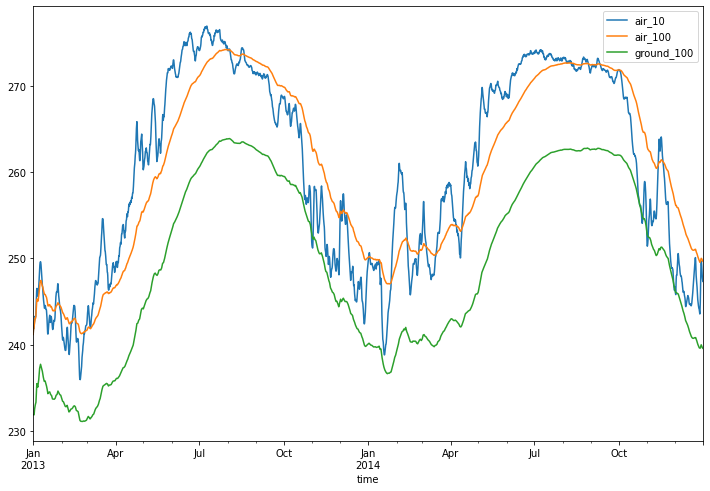

In [13]:
_ = results.isel(lat=0, lon=0).drop(["lat", "lon"]).to_dataframe().plot(figsize=(12, 8))